# 05 - Grad-CAM Visualizations

This notebook uses Grad-CAM to visualize where the ResNet18-LSTM model focused its attention when predicting myocardial infarction (MI) from echocardiographic frames.


In [1]:
import pickle

# Adjust path if needed (relative to where you're running this)
with open("a4c_video_splits.pkl", "rb") as f:
    splits = pickle.load(f)

# Unpack
train_videos = splits["train_videos"]
val_videos = splits["val_videos"]
final_test_videos = splits["final_test_videos"]
train_labels = splits["train_labels"]
val_labels = splits["val_labels"]
final_test_labels = splits["final_test_labels"]

print(f"Train: {len(train_videos)} | Val: {len(val_videos)} | Test: {len(final_test_videos)}")



Train: 101 | Val: 13 | Test: 13


In [2]:
from torch.utils.data import Dataset, DataLoader, Subset
import glob
from PIL import Image
import torch
import numpy as np
import random
np.random.seed(2020)
random.seed(2020)
torch.manual_seed(2020)
class VideoDataset(Dataset):
    def __init__(self, ids, labels, transform, timesteps=16, split="training"):
        self.transform = transform
        self.ids = ids
        self.labels = labels
        self.timesteps = timesteps
        self.split = split.lower()  

       
        self.folder_map = {
            "training": "a4c_jpg_training",
            "validation": "a4c_jpg_validation",
            "test": "a4c_jpg_test",
        }

        
        if self.split not in self.folder_map:
            raise ValueError(f"Invalid split: {self.split}. Must be one of {list(self.folder_map.keys())}.")

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        target_folder = self.folder_map[self.split]

        
        frame_path = self.ids[idx]
        folder_path = frame_path.replace("A4C", target_folder).replace(".avi", "")
        

        
        path2imgs = sorted(glob.glob(os.path.join(folder_path, "*.jpg")))
        if len(path2imgs) == 0:
            raise ValueError(f"No frames found in folder: {folder_path}")

        
        path2imgs = path2imgs[:self.timesteps]

        
        label = self.labels[idx]

        frames = []
        for p2i in path2imgs:
            frame = Image.open(p2i).convert("RGB")  
            frames.append(self.transform(frame))

        if len(frames) == 0:
            raise ValueError(f"No valid frames found for video in folder: {folder_path}")

        
        frames_tr = torch.stack(frames)
        return frames_tr, label


In [3]:
model_type = "rnn"    

timesteps =16
if model_type == "rnn":
    h, w =224, 224
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
else:
    h, w = 112, 112
    mean = [0.43216, 0.394666, 0.37645]
    std = [0.22803, 0.22145, 0.216989]

In [4]:
import torchvision.transforms as transforms

train_transformer = transforms.Compose([
            transforms.Resize((h,w)),
            transforms.RandomHorizontalFlip(p=0.5),  
            transforms.RandomAffine(degrees=0, translate=(0.1,0.1)),    
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
            ])

val_transformer = transforms.Compose([
            transforms.Resize((h, w)),
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
])

final_test_transformer = transforms.Compose([
    transforms.Resize((h, w)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

In [7]:
import os
import torchvision.transforms as transforms


train_ds = VideoDataset(
    ids=[v.replace("A4C", "A4c_jpg_training") for v in train_videos],
    labels=train_labels,
    transform=train_transformer,
    split="training"
)
print(f"Training set size: {len(train_ds)}")


val_ds = VideoDataset(
    ids=[v.replace("A4C", "A4c_jpg_validation") for v in val_videos],
    labels=val_labels,
    transform=val_transformer,
    split="validation"
)
print(f"Validation set size: {len(val_ds)}")

# Final Test Dataset
final_test_ds = VideoDataset(
    ids=[v.replace("A4C", "A4c_jpg_test") for v in final_test_videos],
    labels=final_test_labels,
    transform=final_test_transformer,
    split="test"
)
print(f"Final test set size: {len(final_test_ds)}")

Training set size: 101
Validation set size: 13
Final test set size: 13


In [8]:
imgs, label = train_ds[10]
imgs.shape, label, torch.min(imgs), torch.max(imgs)

(torch.Size([16, 3, 224, 224]), 0, tensor(-2.1179), tensor(2.5529))

In [9]:
import myutils

In [10]:
# Define the reverse mapping from label integer to class name
idx_to_label_dict = {0: 'non_mi', 1: 'mi'}

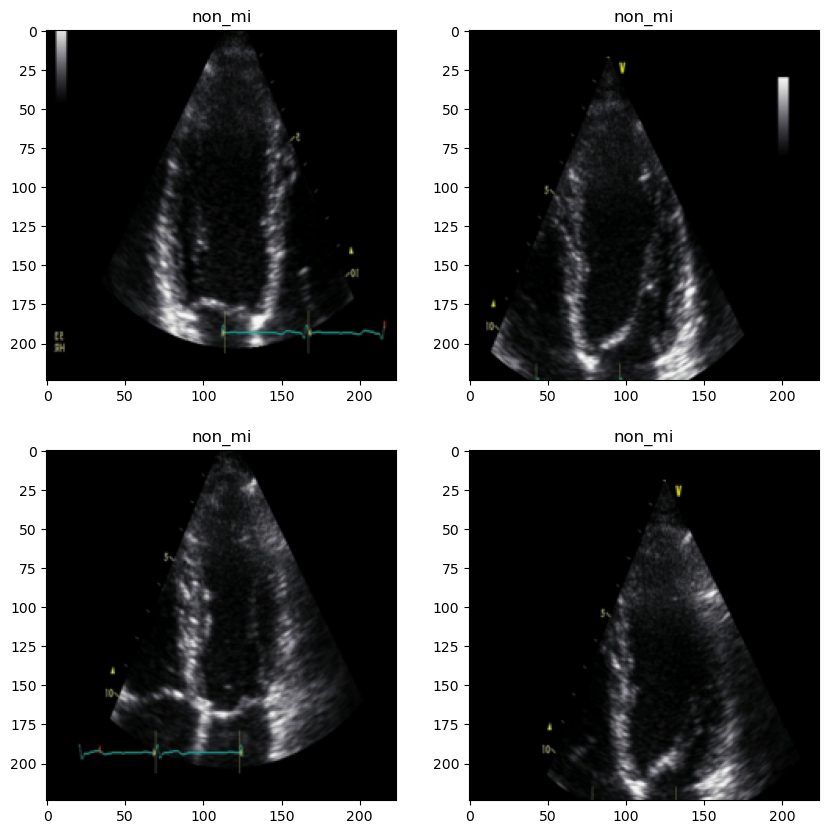

In [11]:
import matplotlib.pylab as plt
%matplotlib inline

plt.figure(figsize=(10,10))
for ii,img in enumerate(imgs[::4]):
    plt.subplot(2,2,ii+1)
    plt.imshow(myutils.denormalize(img, mean, std))
    plt.title(idx_to_label_dict[label])

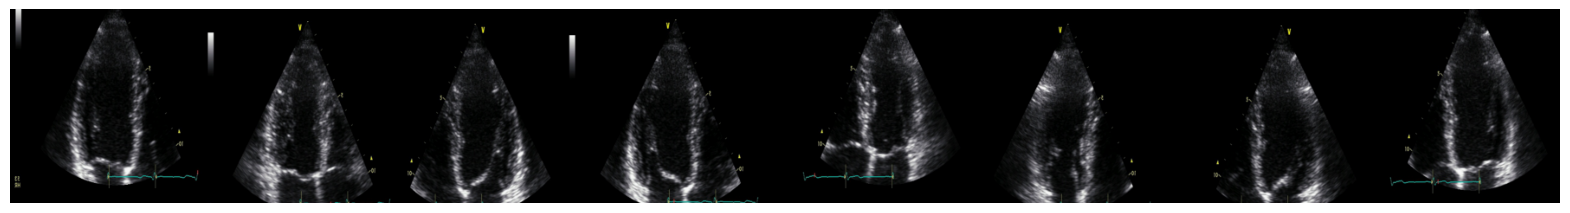

In [12]:
import matplotlib.pylab as plt
%matplotlib inline

plt.figure(figsize=(20,20))
plt.subplots_adjust(wspace=0, hspace=0)
for ii,img in enumerate(imgs[::2]):
    plt.subplot(1,8,ii+1)
    plt.imshow(myutils.denormalize(img, mean, std))
    plt.axis("off")

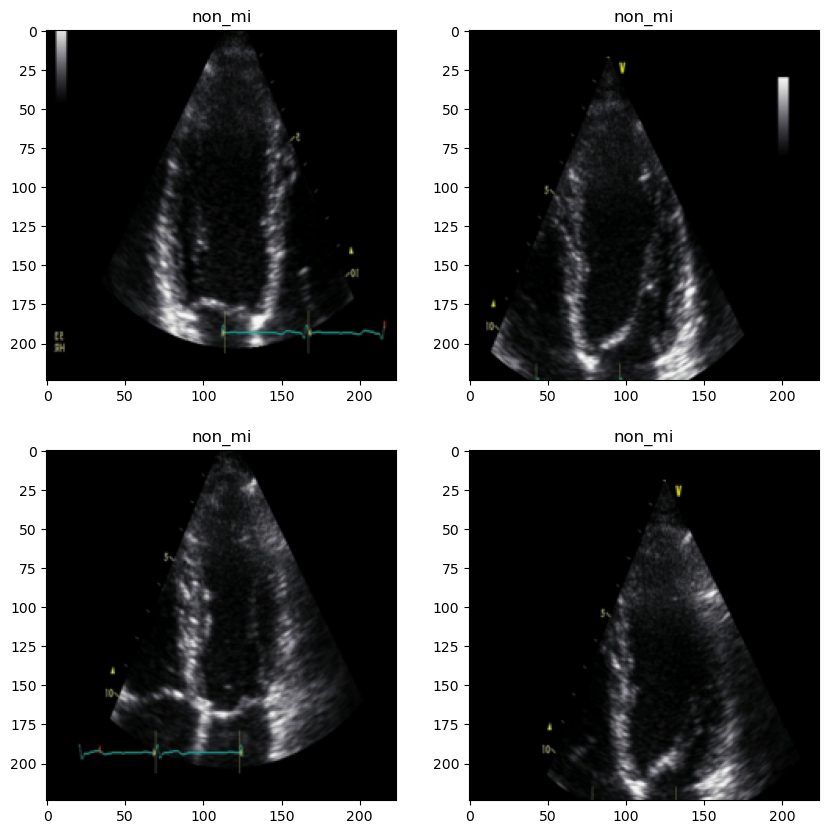

In [13]:
plt.figure(figsize=(10,10))
for ii,img in enumerate(imgs[::4]):
    plt.subplot(2,2,ii+1)
    plt.imshow(myutils.denormalize(img, mean, std))
    plt.title(idx_to_label_dict[label])

In [14]:
def collate_fn_r3d_18(batch):
    imgs_batch, label_batch = list(zip(*batch))
    imgs_batch = [imgs for imgs in imgs_batch if len(imgs)>0]
    label_batch = [torch.tensor(l) for l, imgs in zip(label_batch, imgs_batch) if len(imgs)>0]
    imgs_tensor = torch.stack(imgs_batch)
    imgs_tensor = torch.transpose(imgs_tensor, 2, 1)
    labels_tensor = torch.stack(label_batch)
    return imgs_tensor,labels_tensor

def collate_fn_rnn(batch):
    imgs_batch, label_batch = list(zip(*batch))
    imgs_batch = [imgs for imgs in imgs_batch if len(imgs)>0]
    label_batch = [torch.tensor(l) for l, imgs in zip(label_batch, imgs_batch) if len(imgs)>0]
    imgs_tensor = torch.stack(imgs_batch)
    labels_tensor = torch.stack(label_batch)
    return imgs_tensor,labels_tensor
    

batch_size = 1
if model_type == "rnn":
    train_dl = DataLoader(train_ds, batch_size= batch_size,
                          shuffle=True, collate_fn= collate_fn_rnn)
    val_dl = DataLoader(val_ds, batch_size= batch_size,
                          shuffle=True, collate_fn= collate_fn_rnn)
    test_dl = DataLoader(final_test_ds, batch_size= batch_size,
                         shuffle=False, collate_fn= collate_fn_rnn)  
else:
    train_dl = DataLoader(train_ds, batch_size= batch_size,
                          shuffle=True, collate_fn= collate_fn_r3d_18)
    val_dl = DataLoader(val, batch_size= batch_size,
                          shuffle=True, collate_fn= collate_fn_r3d_18)
    test_dl = DataLoader(final_test_ds, batch_size= batch_size,
                         shuffle=False, collate_fn= collate_fn_r3d_18)

In [15]:
for xb,yb in train_dl:
    print(xb.shape, yb.shape)
    break

torch.Size([1, 16, 3, 224, 224]) torch.Size([1])


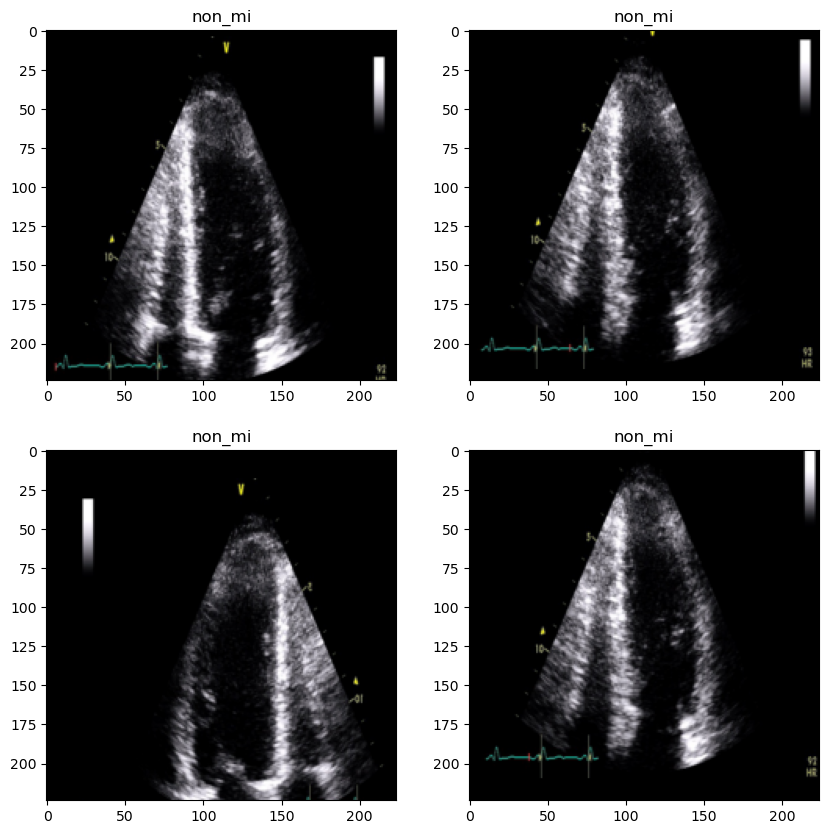

In [16]:
imgs = xb[0]
label = yb[0]
%matplotlib inline

plt.figure(figsize=(10,10))
for ii,img in enumerate(imgs[::4]):
    plt.subplot(2,2,ii+1)
    plt.imshow(myutils.denormalize(img, mean, std))
    plt.title(idx_to_label_dict[label.item()])

In [17]:
for xb,yb in test_dl:
    print(xb.shape, yb.shape)
    break

torch.Size([1, 16, 3, 224, 224]) torch.Size([1])


In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
class Resnt18Rnn(nn.Module):
    def __init__(self, params_model):
        super(Resnt18Rnn, self).__init__()
        num_classes = params_model["num_classes"]
        dr_rate= params_model["dr_rate"]
        pretrained = params_model["pretrained"]
        rnn_hidden_size = params_model["rnn_hidden_size"]
        rnn_num_layers = params_model["rnn_num_layers"]
        
        baseModel = models.resnet18(pretrained=pretrained, progress=False)
        num_features = baseModel.fc.in_features
        baseModel.fc = Identity()
        self.baseModel = baseModel
        self.dropout = nn.Dropout(dr_rate)
        self.rnn = nn.LSTM(num_features, rnn_hidden_size, rnn_num_layers, batch_first=True)
        self.fc1 = nn.Linear(rnn_hidden_size, num_classes)
        
        self.attn = nn.Linear((rnn_hidden_size * 2), rnn_hidden_size)
        self.v = nn.Linear(rnn_hidden_size, 1, bias=False)
        
        # Track gradients for GradCAM
        self.gradients = None
        self.activations = None

    def activations_hook(self, grad):
        """Hook to store gradients for GradCAM"""
        self.gradients = grad

    def forward(self, x):
        b_z, ts, c, h, w = x.shape
        output_list = []

        for ii in range(ts):
            # Extract activations from the base model
            y = self.baseModel(x[:, ii])  # Shape: [batch, features]
            
            # Register hook for gradients on the activations
            if ii == 0:  # We only register for the first frame
                self.activations = y
                self.activations.register_hook(self.activations_hook)
            
            out, (hn, cn) = self.rnn(y.unsqueeze(1)) if ii == 0 else self.rnn(y.unsqueeze(1), (hn, cn))
            output_list.append(out)

        output_list = torch.stack(output_list).squeeze(2)
        output_list = output_list.permute(1, 0, 2)
        
        out = self.dropout(out[:, -1])
        out = self.fc1(out)
        return out

    def get_activations_gradient(self):
        """Return gradients that were saved during the forward pass"""
        return self.gradients
    
    def get_activations(self, x):
        """Return activations for the first frame"""
        return self.activations


In [19]:
class GradCamModel(nn.Module):
    def __init__(self, params_model):
        super(GradCamModel, self).__init__()
        num_classes = params_model["num_classes"]
        dr_rate= params_model["dr_rate"]
        pretrained = params_model["pretrained"]
        rnn_hidden_size = params_model["rnn_hidden_size"]
        rnn_num_layers = params_model["rnn_num_layers"]
        model_shits_1 = []
        model_shits_2 = []
        for i in range(timesteps):
            model = Resnt18Rnn(params_model)
            model.load_state_dict(torch.load("../models/weights_a4c_"+model_type+".pt"))
            baseModel = model.baseModel
            model_shits_1.append(nn.Sequential(*list(baseModel.children())[:-2]))
            model_shits_2.append(nn.Sequential(*list(baseModel.children())[-2:]))
            self.gradients = []
        self.model_shits_1 = nn.ModuleList(model_shits_1)
        self.model_shits_2 = nn.ModuleList(model_shits_2)
        self.rnn = model.rnn
        self.fc1 = model.fc1
        
        self.attn = nn.Linear((rnn_hidden_size * 2), rnn_hidden_size)
        self.v = nn.Linear(rnn_hidden_size, 1, bias = False)

        
    def activations_hook(self, grad):
        self.gradients.append(grad)

    def forward(self, x):
        self.gradients = []
        # Ensure that the input tensor requires gradients
        x = x.requires_grad_()  # This line ensures that x requires gradients
        b_z, ts, c, h, w = x.shape
        ii = 0

        # Register hook for the first timestep
        y_1 = self.model_shits_1[ii](x[:, ii])
        if not y_1.requires_grad:
            y_1.requires_grad_()  # Ensure y_1 requires gradients

        h = y_1.register_hook(self.activations_hook)  # This should work now
        y = self.model_shits_2[ii](y_1)
        y = y.view(b_z, -1)

        output_list = []
        output, (hn, cn) = self.rnn(y.unsqueeze(1))
        output_list.append(output)
    
        for ii in range(1, ts):
            y_1 = self.model_shits_1[ii](x[:, ii])
            if not y_1.requires_grad:
                y_1.requires_grad_()  # Ensure y_1 requires gradients

            h = y_1.register_hook(self.activations_hook)  # This should work now

            y = self.model_shits_2[ii](y_1)
            y = y.view(b_z, -1)
            out, (hn, cn) = self.rnn(y.unsqueeze(1), (hn, cn))
            output_list.append(out)

        output_list = torch.stack(output_list).squeeze(2)
        output_list = output_list.permute(1, 0, 2)

        out = out[:, -1].squeeze(1)
        src_len = output_list.shape[1]
        hidden = out.unsqueeze(1).repeat(1, src_len, 1)

        energy = torch.tanh(self.attn(torch.cat((hidden, output_list), dim=2)))
        attention = self.v(energy).squeeze(2)
        a = F.softmax(attention, dim=1)
        a = a.unsqueeze(1)

        weighted = torch.bmm(a, output_list)
        out = weighted[:, 0, :]
        out = self.fc1(out)
        return out

    
    
    # method for the gradient extraction
    def get_activations_gradient(self):
        return torch.stack(self.gradients, dim=2)
    
    # method for the activation exctraction
    def get_activations(self, x):
        ts = x.shape[1]
        ii = 0
#         model = self.grad_models[ii]
#         baseModel = model.baseModel
#         model_shit_1 = nn.Sequential(*list(baseModel.children())[:-2])
        activations = []
        for ii in range(ts):
            activations.append(self.model_shits_1[ii]((x[:,ii])))
        return torch.stack(activations, dim=2)
    
    
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
    def forward(self, x):
        return x


In [20]:
num_classes = 2 

In [21]:
from torchvision import models
params_model={
        "num_classes": num_classes,
        "dr_rate": 0.1,
        "pretrained" : True,
        "rnn_num_layers": 1,
        "rnn_hidden_size": 100,}

In [22]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = 'cpu'

In [23]:
# y.requires_grad
def denormalize(x_, mean, std):
    x = x_.clone()
    for i in range(3):
        x[i] = x[i]*std[i]+mean[i]
    return x

In [24]:
a = iter(train_dl)

In [25]:
torch.save(xb,'clap_video')

In [26]:
yb

tensor([1])

In [27]:
model = GradCamModel(params_model)
#     model.train()
torch.backends.cudnn.enabled = False
model = model.to(device)
fuck = model.eval()
output= model(xb)

C:\Users\sa\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\sa\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [28]:
# for xb, yb in test_dl:
while True :
#     model = GradCamModel(params_model)
#     #     model.train()
#     torch.backends.cudnn.enabled = False
#     model = model.to(device)
#     model.eval()
    xb, yb  = next(a)
    xb=xb.to(device)
    yb=yb.to(device)
    output=model(xb)
    print(idx_to_label_dict[output.argmax(dim=1).item()])
    if yb.item()==output.argmax(dim=1).item():
        break
yb, output.argmax(dim=1), idx_to_label_dict[yb.item()], idx_to_label_dict[output.argmax(dim=1).item()]

mi


(tensor([1]), tensor([1]), 'mi', 'mi')

In [29]:
c = yb
activations = model.get_activations(xb).detach()
activations.shape

torch.Size([1, 512, 16, 7, 7])

In [30]:
model.zero_grad()
output[:,c].backward()
gradients = model.get_activations_gradient()
# pool the gradients across the channels
pooled_gradients = torch.mean(gradients, dim=[0, 3, 4])
print(gradients.shape, pooled_gradients.shape)
activations = model.get_activations(xb).detach()
channels, n_frames = activations.shape[1], activations.shape[2]
for i in range(channels):
    for j in range(n_frames):
        activations[:,i,j,:,:]*= pooled_gradients[i,j]
        
heatmap = torch.mean(activations, dim=1).squeeze().cpu()
heatmap = np.maximum(heatmap,0)
for i in range(n_frames):
    heatmap[i]/=torch.max(heatmap[i])
heatmap = heatmap.numpy()

torch.Size([1, 512, 16, 7, 7]) torch.Size([512, 16])


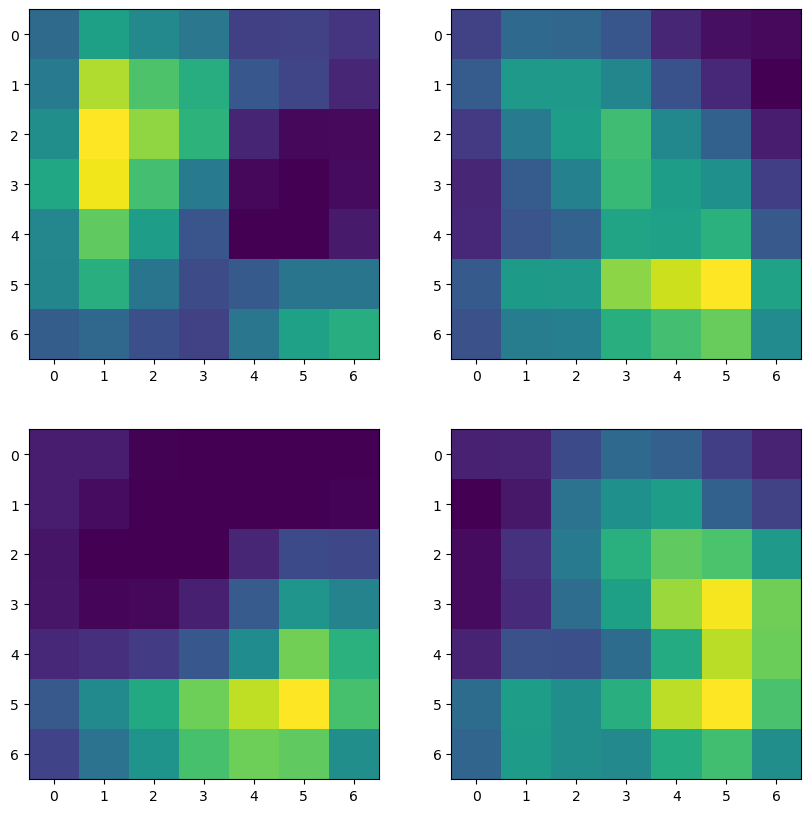

In [31]:
%matplotlib inline

plt.figure(figsize=(10,10))
for ii, _ in enumerate(range(0,n_frames,4)):
    plt.subplot(2,2,ii+1)
    plt.imshow(heatmap[ii])
#     plt.title(idx_to_label_dict[label.item()])

In [37]:
import os
import torch
import cv2
import numpy as np
from PIL import Image
import myutils

def save_gradcam_frames_and_video(
    model, 
    folder_path,
    mean,
    std,
    device='cpu',
    transform=None,
    output_frames_dir='gradcam_frames',
    output_video_path='gradcam_video.mp4',
    fps=5,
    blur_kernel_size=(5, 5)
):
    print(f" Loading frames from {folder_path}")
    
    # Load and sort frame paths
    frame_paths = sorted([os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.jpg')])
    if not frame_paths:
        print(" No frames found.")
        return
    
    # Load frames with transform
    frames = [transform(Image.open(p).convert("RGB")) for p in frame_paths]
    video_tensor = torch.stack(frames).unsqueeze(0).to(device).requires_grad_()

    model.eval()
    output = model(video_tensor)
    predicted_class = output.argmax(dim=1).item()
    print(f" Predicted class: {predicted_class} ({'MI' if predicted_class else 'non-MI'})")

    # Grad-CAM
    model.zero_grad()
    output[0, predicted_class].backward()
    gradients = model.get_activations_gradient()
    pooled_gradients = torch.mean(gradients, dim=[2, 3])
    activations = model.get_activations(video_tensor).detach()
    pooled_gradients = pooled_gradients.unsqueeze(2).unsqueeze(3)

    for i in range(activations.shape[1]):
        activations[:, i, :, :, :] *= pooled_gradients[:, i, :, :]

    heatmap = torch.mean(activations, dim=1).squeeze().cpu().numpy()
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)


    os.makedirs(output_frames_dir, exist_ok=True)

    for i, path in enumerate(frame_paths):
        img = myutils.denormalize(video_tensor[0, i], mean, std)
        img = np.array(img)

        # Resize and apply heatmap
        heatmap_resized = cv2.resize(heatmap[i], (img.shape[1], img.shape[0]))
        heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
        superimposed_img = cv2.addWeighted(heatmap_color, 0.4, img, 0.6, 0)
        out_path = os.path.join(output_frames_dir, f'gradcam_frame_{i + 1}.jpg')
        cv2.imwrite(out_path, superimposed_img)
        print(f" Saved: {out_path}")

    # Make video
    frame_example = cv2.imread(os.path.join(output_frames_dir, 'gradcam_frame_1.jpg'))
    h, w, _ = frame_example.shape
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out_video = cv2.VideoWriter(output_video_path, fourcc, fps, (w, h))

    for i in range(len(frame_paths)):
        frame_path = os.path.join(output_frames_dir, f'gradcam_frame_{i + 1}.jpg')
        frame = cv2.imread(frame_path)
        out_video.write(frame)

    out_video.release()
    print(f" Saved Grad-CAM video to {output_video_path}")




In [38]:
device = 'cpu'

In [39]:
save_gradcam_frames_and_video(
    model=model,
    folder_path='../data/A4C_jpg_test/ES000162 n_4CH_1',
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225],
    transform=val_transformer,
    device='cpu',
    output_frames_dir='./gradcam_frames',
    output_video_path='./gradcam_output.mp4',
    fps=5
)





 Loading frames from ../data/A4C_jpg_test/ES000162 n_4CH_1
 Predicted class: 0 (non-MI)
 Saved: ./gradcam_frames\gradcam_frame_1.jpg
 Saved: ./gradcam_frames\gradcam_frame_2.jpg
 Saved: ./gradcam_frames\gradcam_frame_3.jpg
 Saved: ./gradcam_frames\gradcam_frame_4.jpg
 Saved: ./gradcam_frames\gradcam_frame_5.jpg
 Saved: ./gradcam_frames\gradcam_frame_6.jpg
 Saved: ./gradcam_frames\gradcam_frame_7.jpg
 Saved: ./gradcam_frames\gradcam_frame_8.jpg
 Saved: ./gradcam_frames\gradcam_frame_9.jpg
 Saved: ./gradcam_frames\gradcam_frame_10.jpg
 Saved: ./gradcam_frames\gradcam_frame_11.jpg
 Saved: ./gradcam_frames\gradcam_frame_12.jpg
 Saved: ./gradcam_frames\gradcam_frame_13.jpg
 Saved: ./gradcam_frames\gradcam_frame_14.jpg
 Saved: ./gradcam_frames\gradcam_frame_15.jpg
 Saved: ./gradcam_frames\gradcam_frame_16.jpg
 Saved Grad-CAM video to ./gradcam_output.mp4
